# Training a multivariate discrimination

Below we prepare a simple setup to train a multivariate discriminator to separate the signal from the background.
It's meant just an appetizer for you to explore. After you go through it it may be a good occasion to put in practice what you learned in the short exercise about Machine Learning!

In [1]:
# if the import of mplhep fails follow instructions in Event-selection-optimization.ipynb
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import mplhep
from matplotlib.colors import LogNorm

In [2]:
#global configurarables
proton_selection = "MultiRP"

#Execute this line if running on SWAN, otherwise update the path to the data files:
PATH='/eos/home-c/cmsdas/2023/long-ex-dilep/h5py'
#PATH='output'

#eras=['B','C','D','E','F'] #uncomment to use all data
eras=['B']
stream='Mu' # 'El' OR 'Mu'

## Collect the data and simulation

The following cell is used to load the training data to memory. Further pre-selection will be applied below.

The data which we are going to use to model the background has been pre-processed with an event mixing technique.
For each event the reconstructed protons have been substituted with protons from another event,
guaranteeing that there is no correlation between the central event and the one reconstucted in the PPS.

In [3]:
#we'll load the GetData helper function from a snippet to avoid overloading the notebook with secondary code
#%load_ext autoreload
#%autoreload 2
from snippets.GetData import *

In [4]:
print('[Signal simulation]')
df_signal,df_counts_signal = GetData(PATH+'/output-GGTo{}_Elastic_v0_SignalOnly.h5'.format('EE' if stream=='El' else 'MuMu'), is2018=True)
print('Selection counts')
print(df_counts_signal)

[Signal simulation]
	Returning the result of 1 merged datasets
Selection counts
All        447194
Lepton      69588
Vertex      69588
Protons     39261
dtype: int64


In [5]:
print('\n')
print('[Data (to be used as background)]')
data_files = [PATH+'/output-UL2018{}-{}-Rand20.h5'.format(era,stream) for era in eras]

df_bkg,df_counts_bkg = GetData(data_files,chunk_size=1000000, is2018=True)
print('Selection counts')
print(df_counts_bkg)



[Data (to be used as background)]
	Returning the result of 16 merged datasets
Selection counts
All           89753820
Lepton         2945460
Vertex         2945460
ProtonsRnd     2500120
dtype: int64


## Prepare the data

We apply the following selection to the signal and data

* require $m_{ll}>110$ GeV
* set the dilepton xi according to the arm where a proton was reconstructed 
* use the proton reconstruction algorithm as required at the start of the notebook

After preparing the data we take a look at the correlations of the features (variables) of interest. How do the correlations differ for signal and background?

In [6]:
def PrepareData(df):
    
    """applies baseline selection cuts"""

    #mks = (( df["InvMass"] >= 110. ) & ( df["Acopl"] <= 0.003 ) & ( df["ExtraPfCands_v2"] <= 3 ))
    msk = ( df["InvMass"] >= 110. )

    msk1 = None
    msk2 = None
    if proton_selection == "SingleRP":
        # Single-RP in pixel stations
        msk1_arm = ( df["RPId1"] == 23 )
        msk2_arm = ( df["RPId1"] == 123 )
        multiRP=0
    elif proton_selection == "MultiRP":
        # Multi-RP
        msk1_arm = ( df["Arm"] == 0 )
        msk2_arm = ( df["Arm"] == 1 )
        multiRP=1
   
    df[ "XiMuMu" ] = np.nan
    df[ "XiMuMu" ].where( ~msk1_arm, df[ "XiMuMuPlus" ],  inplace=True )
    df[ "XiMuMu" ].where( ~msk2_arm, df[ "XiMuMuMinus" ], inplace=True )
    msk1 = msk & ( df["MultiRP"] == multiRP) & msk1_arm
    msk2 = msk & ( df["MultiRP"] == multiRP) & msk2_arm
   
    return df[msk1 | msk2].copy()

df_signal_prep = PrepareData(df_signal)
df_bkg_prep    = PrepareData(df_bkg)
print("signal sample size = %d\nBackground sample size = %d"%(df_signal_prep.shape[0],df_bkg_prep.shape[0]))

signal sample size = 31652
Background sample size = 1879534


In [7]:
#If background sample size is too large, consider to reduce it:
df_bkg_prep=df_bkg_prep.sample(frac=df_signal_prep.shape[0]/df_bkg_prep.shape[0])
print("Background sample new size = %d"%(df_bkg_prep.shape[0]))

Background sample new size = 31652


Signal prepared (31652, 21)
['Lep0Pt', 'Lep1Pt', 'InvMass', 'XiMuMu', 'Xi', 'Acopl', 'PV_ndof']


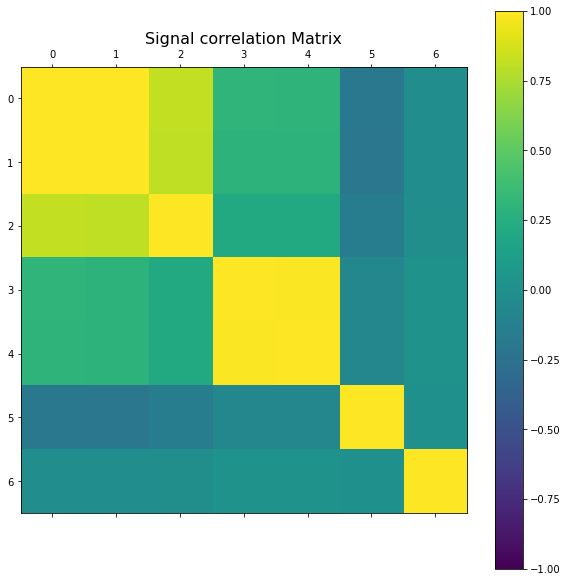

,Lep0Pt,Lep1Pt,InvMass,XiMuMu,Xi,Acopl,PV_ndof
2,77.174400,76.391220,153.820419,0.034153,0.034584,0.001596,0
5,52.779865,52.659855,169.868958,0.046795,0.048218,0.002664,2
8,90.872391,90.620186,333.883392,0.048729,0.046295,0.000702,1
11,146.451569,145.635681,466.947876,0.061356,0.061852,0.000469,7
14,57.223656,54.135593,112.835686,0.078966,0.081589,0.001713,0
17,82.375107,79.323273,179.429504,0.056148,0.057137,0.000269,4
20,57.064232,56.573280,113.779678,0.052263,0.050797,0.000333,0
23,126.620819,122.230690,537.153870,0.108878,0.114685,0.000308,0
26,76.909264,75.908066,152.998093,0.062070,0.065750,0.000852,11
29,52.127430,52.004093,139.791016,0.027358,0.027328,0.000269,19


In [8]:
print('Signal prepared',df_signal_prep.shape)

train_vars=['Lep0Pt', 'Lep1Pt', 'InvMass',   'XiMuMu', 'Xi', 'Acopl','PV_ndof']

#draw the correlation matrix for the training variables
print(train_vars)
fig=plt.figure(figsize=(10, 10))
plt.matshow(df_signal_prep[train_vars].corr(), fignum=fig.number)
cb = plt.colorbar()
plt.clim(-1,1)
plt.title('Signal correlation Matrix', fontsize=16)
plt.show()

df_signal_prep[train_vars].head(10)

Background prepared (31652, 21)
['Lep0Pt', 'Lep1Pt', 'InvMass', 'XiMuMu', 'Xi', 'Acopl', 'PV_ndof']


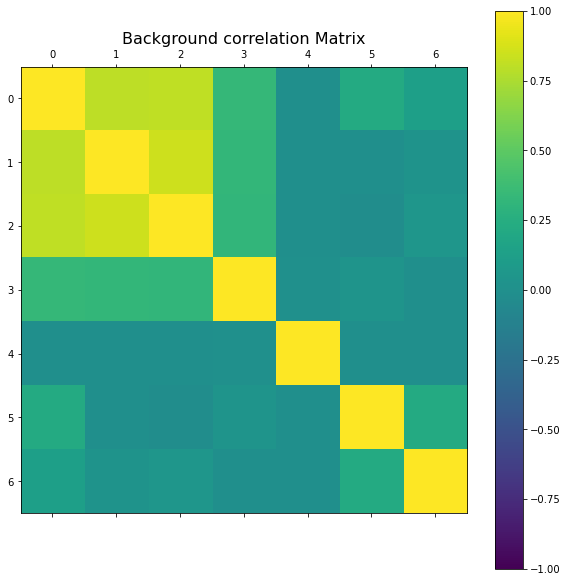

,Lep0Pt,Lep1Pt,InvMass,XiMuMu,Xi,Acopl,PV_ndof
375834,82.459183,67.632660,159.153885,0.010179,0.066147,0.036600,14
472543,128.583771,105.759315,256.807709,0.032214,0.099014,0.034657,37
359525,104.663498,62.396648,165.461227,0.005772,0.094727,0.388054,91
119383,78.191612,70.268082,149.965942,0.061145,0.115662,0.004199,85
274327,78.072998,71.360352,152.397552,0.034198,0.072495,0.026270,75
661906,63.972282,62.041954,130.257080,0.001244,0.122726,0.030946,36
737255,69.863617,50.018013,158.353073,0.007876,0.073044,0.084859,94
466917,361.030762,212.983978,681.529724,0.008766,0.142822,0.120146,45
497310,170.291077,99.477814,253.242859,0.004453,0.126068,0.290414,67
959491,69.159859,53.819183,119.535675,0.009250,0.124420,0.244286,51


In [9]:
print('Background prepared',df_bkg_prep.shape)

#draw the correlation matrix for these variables
print(train_vars)
fig=plt.figure(figsize=(10, 10))
plt.matshow(df_bkg_prep[train_vars].corr(), fignum=fig.number)
cb = plt.colorbar()
plt.clim(-1,1)
plt.title('Background correlation Matrix', fontsize=16)
plt.show()

df_bkg_prep[train_vars].head(10)

## Model building

Having the data prepared we now turn to building a simple model using the same training variables inspected above.
`sklearn` is used to define the training and test sample and to train a model which will do binary classification (0=background, 1=signal).
The model is based on a [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/tree.html#tree).
The [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) is then used to improve the base training of the DecisionTreeClassifier.

In [10]:
X_sig=df_signal_prep[train_vars].copy()
X_bkg=df_bkg_prep[train_vars].copy()

y_sig = np.ones( len(X_sig) )
y_bkg = np.zeros( len(X_bkg) )

X = pd.concat( [X_sig, X_bkg] ) 
y = np.concatenate( [y_sig, y_bkg] )

In [11]:
#divide into training an testing datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, shuffle=True, random_state=42 )

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

#fit the parameters of the DecisionTreeClassifier
ada_clf = AdaBoostClassifier( DecisionTreeClassifier( max_depth=4 ),
                              n_estimators = 200,
                              algorithm="SAMME.R",
                              learning_rate = 0.5)
ada_clf.fit( X_train, y_train )
clf = ada_clf
print ( clf )

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4),
                   learning_rate=0.5, n_estimators=200)


In [13]:
#save the trained model
from joblib import dump, load
dump(clf, 'pps_longexercise_clf.joblib')

['pps_longexercise_clf.joblib']

## Inspection of the training result

Check the accuracy of the predictions and the receiver-operating characteristic (ROC) curve. 
We use several function from sklearn to do this. 
In case you are not acquainted with them check the following links:
* [accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) -  returns the fraction of correctly classified samples
* [roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) - used to compute the ROC curve for a binary classification
* [roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) - computes the area under the ROC
You'll see that the result is extremely accurate and has a large background rejection power.

**TASK A**

Can you identify which variables contribute mostly to this? (Hint: check for correlations with the classifier, re-train with N-1 variables are some possibilities.
Evaluating the impact via [permutation feature importance](https://scikit-learn.org/stable/modules/permutation_importance.html), will give you already a good hint.
If you are really into it try out a more complex (but also more correct) evaluation in this [example](https://colab.research.google.com/github/GilesStrong/lumin/blob/v0.5.1/examples/Feature_Selection.ipynb) using the [lumin](https://github.com/GilesStrong/lumin) package).

In [14]:
from sklearn.metrics import accuracy_score
y_test_pred = clf.predict( X_test )
print('Accuracy on the test dataset is:',accuracy_score( y_test, y_test_pred ))

y_sig_pred = clf.predict( X_sig )
y_bkg_pred = clf.predict( X_bkg )
print ('Accuracy on the full signal data is', accuracy_score( y_sig, y_sig_pred ) )
print ('Accuracy on the full background data is', accuracy_score( y_bkg, y_bkg_pred ) )

Accuracy on the test dataset is: 0.9973935708079931
Accuracy on the full signal data is 0.9997788449387085
Accuracy on the full background data is 0.9991785669152028


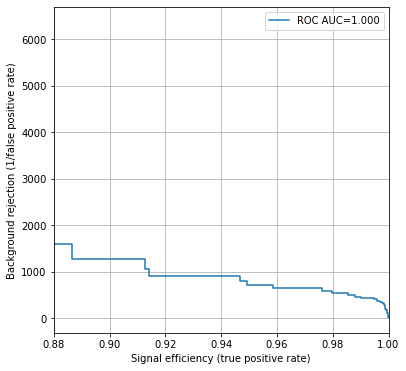

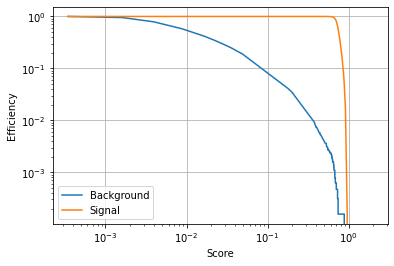

In [15]:
from sklearn import metrics

#get the probability for the event to be signal
y_test_proba = clf.predict_proba(X_test)[:,1]
fpr, tpr,  thresholds = metrics.roc_curve(y_test,  y_test_proba)
auc = metrics.roc_auc_score(y_test, y_test_proba)

fig= plt.figure( figsize=(6,6) )
plt.plot(tpr,
         np.divide(np.ones_like(fpr), fpr, out=np.zeros_like(fpr), where=fpr!=0), 
         label="ROC AUC={:.3f}".format(auc))
plt.legend(loc='best')
plt.ylabel('Background rejection (1/false positive rate)')
plt.xlabel('Signal efficiency (true positive rate)')
plt.xlim(0.88,1.0)
plt.grid()
plt.show()


plt.plot(thresholds,fpr,label='Background')
plt.plot(thresholds,tpr,label='Signal')
plt.xlabel('Score')
plt.ylabel('Efficiency')
plt.legend()
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.show()



Plotting the discriminator shape. The distributions for the signal and background are characterized by a clear separation.

**TASK B**

Can you make an analogous distribution, but for the probability for an event to be background? 
What is the relation between the two?

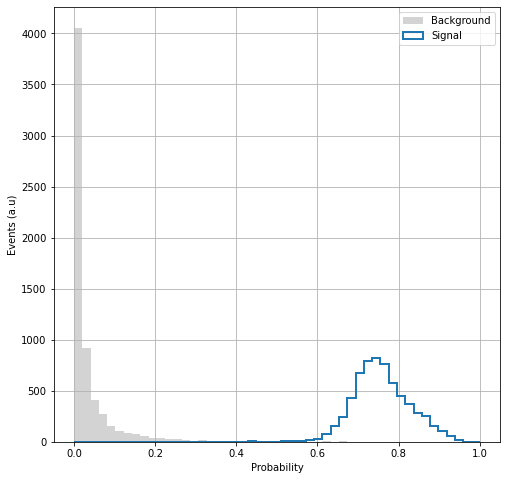

In [16]:
fig = plt.figure( figsize=(8,8) )

bins=np.linspace(0.,1.,50)
plt.hist( y_test_proba[y_test == 0],  color='lightgray', bins=bins, label='Background')
plt.hist( y_test_proba[y_test == 1],  histtype='step',   bins=bins, label='Signal', linewidth=2 )
plt.xlabel('Probability')
plt.ylabel('Events (a.u)')
plt.legend(loc='best')
plt.grid()
plt.show()

In [17]:
def Plot2D(x,y,data_sig,data_bkg,msk_sig,msk_bkg,xran=[0.,0.15],yran=[0.,0.15]):
 
    """a simple routine to plot the signal and background components"""

    fig= plt.figure( figsize=(10,10) )
    plt.plot( data_bkg[x][ msk_bkg ], data_bkg[y][ msk_bkg ], 'ro', label='Background' )
    plt.plot( data_sig[x][ msk_sig ], data_sig[y][ msk_sig ], 'bo', label='Signal' )
    
    if 'Xi' in x and 'Xi' in y:
        plt.plot( xran,yran, 'k--', linewidth=1 )
        plt.plot( xran, [j*0.90 for j in yran], 'k:', linewidth=1 )
        plt.plot( xran, [j*1.10 for j in yran], 'k:', linewidth=1 )

    plt.xlim(*xran)
    plt.xlabel(x)
    plt.ylim(*yran)
    plt.ylabel(y)
    plt.legend(loc='best')

Test dataset: the events classified as signal correlate more strongly in the reconstucted $\xi$ plane. You can compare the result to the one obtained in the Data-Inspection notebook.

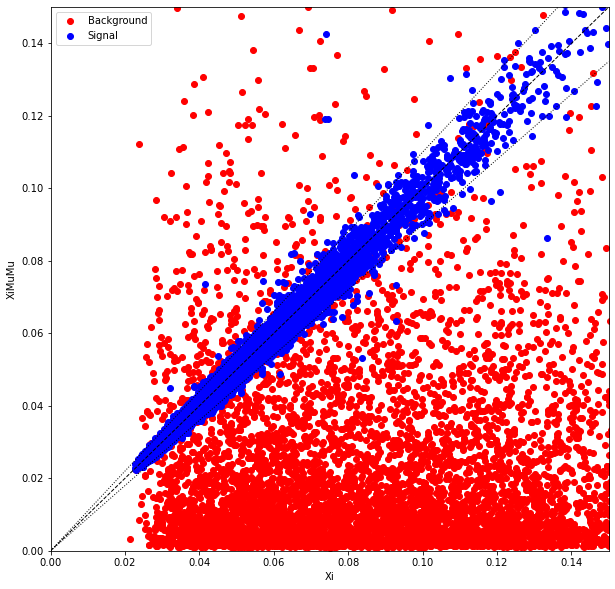

In [18]:
msk_bkg = ( y_test_pred == 0 )
msk_sig = ( y_test_pred == 1 )
Plot2D('Xi','XiMuMu',X_test,X_test,msk_sig,msk_bkg)

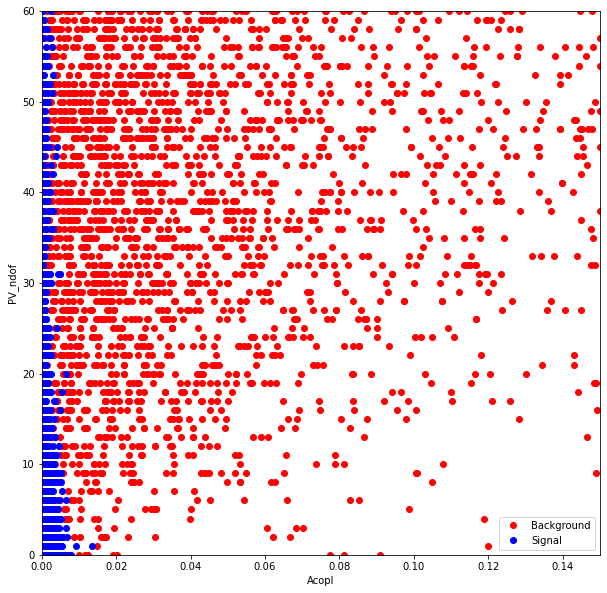

In [19]:
Plot2D('Acopl','PV_ndof',X_test,X_test,msk_sig,msk_bkg,yran=[0,60])

Separate the correlations in the $\xi$ per PPS arm.
Check where the correct predictions in the signal and background datasets lie.

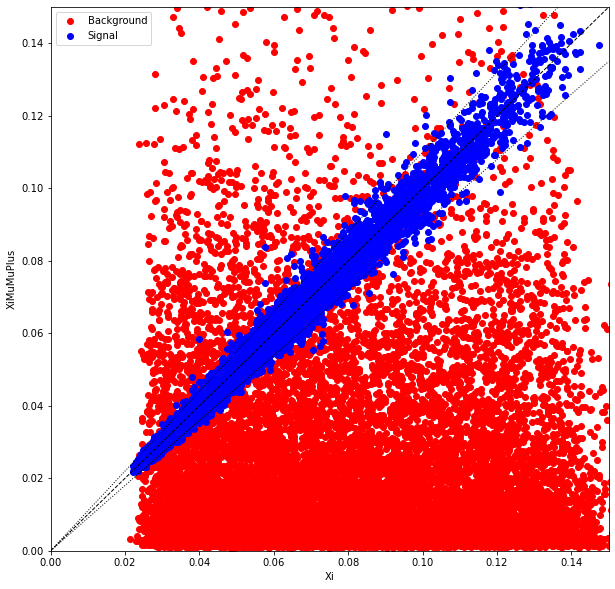

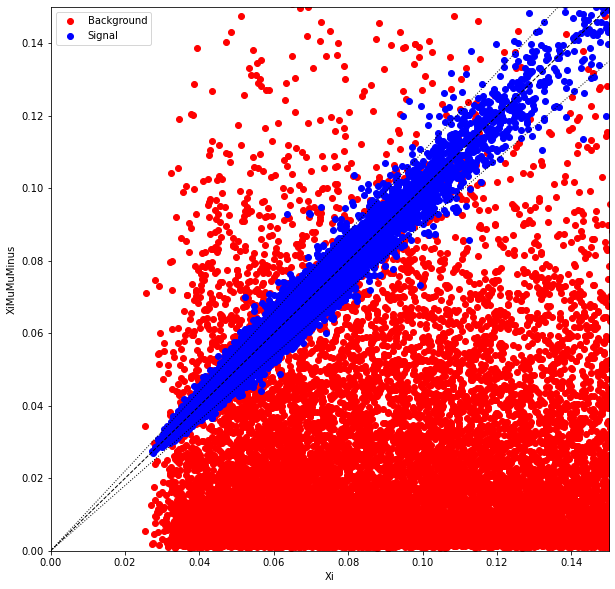

In [20]:
msk_bkg_1 = None
msk_bkg_2 = None
msk_sig_1 = None
msk_sig_2 = None
if proton_selection == "SingleRP":
    msk_bkg_1 = ( df_bkg_prep[ "RPId1" ] == 23 ) & ( y_bkg_pred == 0 )
    msk_bkg_2 = ( df_bkg_prep[ "RPId1" ] == 123 ) & ( y_bkg_pred == 0 )
    msk_sig_1 = ( df_signal_prep[ "RPId1" ] == 23 ) & ( y_sig_pred == 1 )
    msk_sig_2 = ( df_signal_prep[ "RPId1" ] == 123 ) & ( y_sig_pred == 1 )
elif proton_selection == "MultiRP":
    msk_bkg_1 = ( df_bkg_prep[ "Arm" ] == 0 ) & ( y_bkg_pred == 0 )
    msk_bkg_2 = ( df_bkg_prep[ "Arm" ] == 1 ) & ( y_bkg_pred == 0 )
    msk_sig_1 = ( df_signal_prep[ "Arm" ] == 0 ) & ( y_sig_pred == 1 )
    msk_sig_2 = ( df_signal_prep[ "Arm" ] == 1 ) & ( y_sig_pred == 1 )
Plot2D('Xi','XiMuMuPlus',df_signal_prep,df_bkg_prep,msk_sig_1,msk_bkg_1)
Plot2D('Xi','XiMuMuMinus',df_signal_prep,df_bkg_prep,msk_sig_2,msk_bkg_2)

Analogous to the previous set of plots but now we plot the background events which have been wrongly assigned as signal by the predictor.
False positive rate events are a handful events.

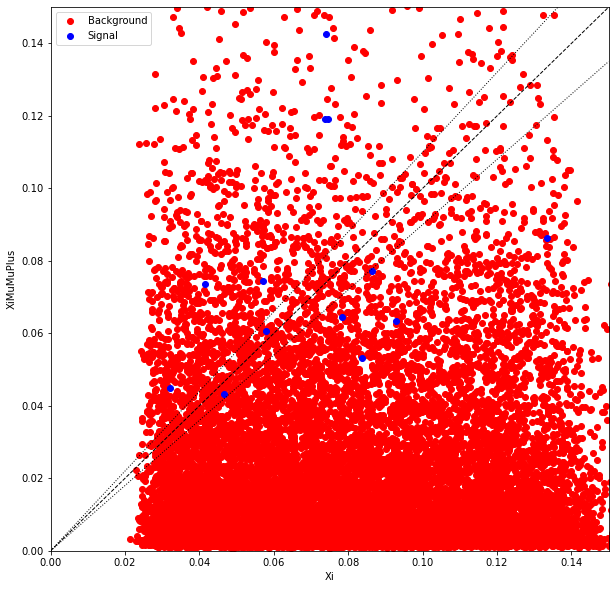

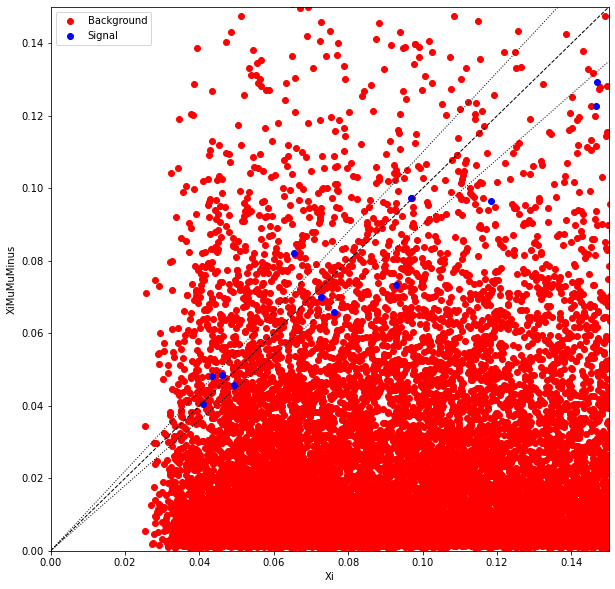

In [21]:
msk_bkgerr_1 = None
msk_bkgerr_2 = None
if proton_selection == "SingleRP":
    msk_bkgerr_1 = ( df_bkg_prep[ "RPId1" ] == 23 ) & ( y_bkg_pred == 1 )
    msk_bkgerr_2 = ( df_bkg_prep[ "RPId1" ] == 123 ) & ( y_bkg_pred == 1 )
elif proton_selection == "MultiRP":
    msk_bkgerr_1 = ( df_bkg_prep[ "Arm" ] == 0 ) & ( y_bkg_pred == 1 )
    msk_bkgerr_2 = ( df_bkg_prep[ "Arm" ] == 1 ) & ( y_bkg_pred == 1 )
Plot2D('Xi','XiMuMuPlus', df_bkg_prep,df_bkg_prep, msk_bkgerr_1, msk_bkg_1)
Plot2D('Xi','XiMuMuMinus',df_bkg_prep,df_bkg_prep, msk_bkgerr_2, msk_bkg_2)

Finally the same distributions but now using events where the signal was misassigned as background.
Also an handful of events is obtained.

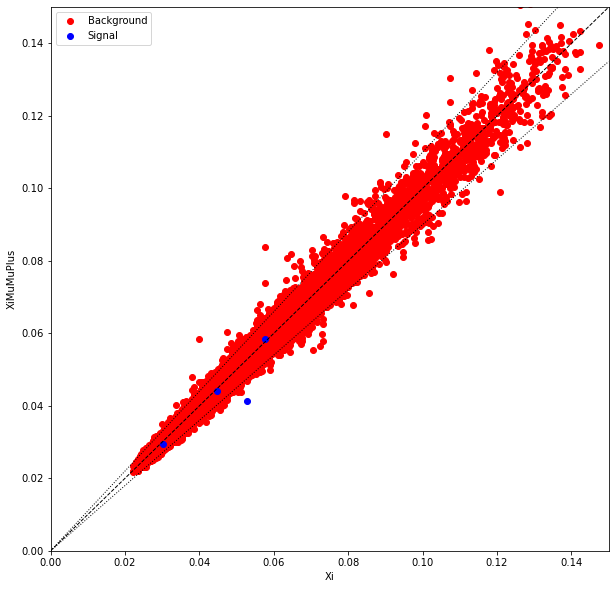

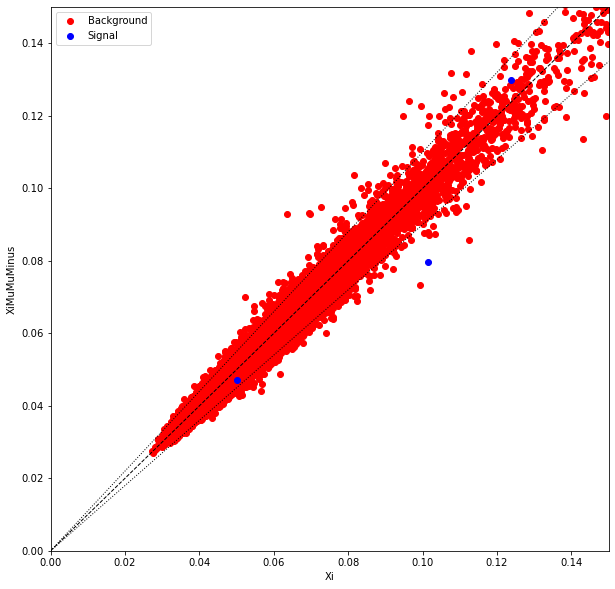

In [22]:
msk_sigerr_1 = None
msk_sigerr_2 = None
if proton_selection == "SingleRP":
    msk_sigerr_1 = ( df_signal_prep[ "RPId1" ] == 23 ) & ( y_sig_pred == 0 )
    msk_sigerr_2 = ( df_signal_prep[ "RPId1" ] == 123 ) & ( y_sig_pred == 0 )
elif proton_selection == "MultiRP":
    msk_sigerr_1 = ( df_signal_prep[ "Arm" ] == 0 ) & ( y_sig_pred == 0 )
    msk_sigerr_2 = ( df_signal_prep[ "Arm" ] == 1 ) & ( y_sig_pred == 0 )
Plot2D('Xi','XiMuMuPlus', df_signal_prep,df_signal_prep, msk_sigerr_1, msk_sig_1)
Plot2D('Xi','XiMuMuMinus',df_signal_prep,df_signal_prep, msk_sigerr_2, msk_sig_2)

Compare the training variable distributions for events classified as signal or background in the test sample.

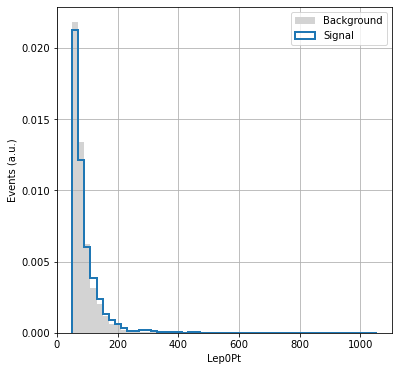

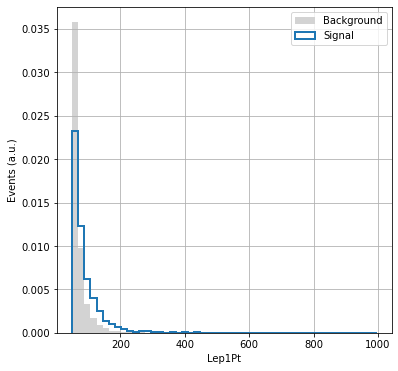

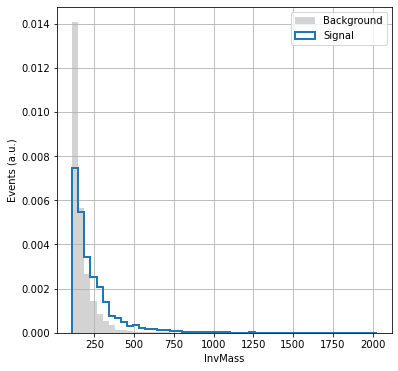

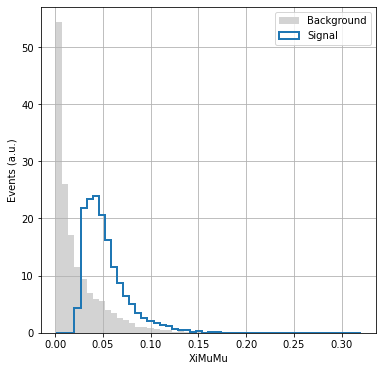

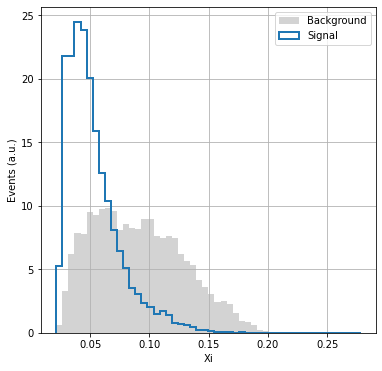

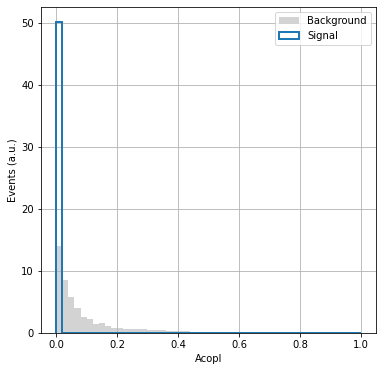

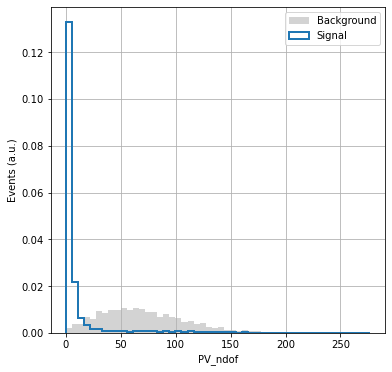

In [23]:
def showDist(x,data,mask_sig, mask_bkg,nbins):
    
    """a simple function to compare signal-like and background-like"""
    
    fig = plt.figure( figsize=(6,6) )
    _,bins=np.histogram(data[x],bins=nbins)
    plt.hist( data[ x ][ mask_bkg ], color='lightgray', bins=bins, density=True, label='Background' )
    plt.hist( data[ x ][ mask_sig ], histtype='step',   bins=bins, density=True, label='Signal', linewidth=2)
    plt.xlabel(x)
    plt.ylabel('Events (a.u.)')
    plt.grid()
    plt.legend(loc='best')
    plt.show()
    
for x in train_vars:
    showDist(x,X_test,(y_test_pred==1),(y_test_pred==0),50)

## Analyze the data using the trained classifier

We now read, prepare and run the prediction for the data. 
The classifier output is used to further select the data and inspect some distributions.

In [24]:
#load the data
print('\n')
print('[Data]')
data_files = [PATH+'/output-UL2018{}-{}.h5'.format(era,stream) for era in eras]
df_data,df_counts_data = GetData(data_files,chunk_size=1000000, is2018=True)
print('Selection counts')
print(df_counts_data)

#prepare the data
df_data_prep=PrepareData(df_data)


#run the prediction
df_data_prep['clf_category'] = clf.predict( df_data_prep[train_vars] ).astype(int)
df_data_prep['clf_prob']     = clf.predict_proba( df_data_prep[train_vars] )[:,1]


df_data_prep.head()



[Data]
	Returning the result of 1 merged datasets
Selection counts
All        4487691
Lepton      147273
Vertex      147273
Protons     125006
dtype: int64


,Run,EventNum,MultiRP,Arm,RPId1,Xi,T,ThX,ThY,Lep0Pt,...,Lep1Eta,Lep1Phi,InvMass,PV_ndof,Acopl,XiMuMuPlus,XiMuMuMinus,XiMuMu,clf_category,clf_prob
4,317087,721564928,1,0,-1,0.093216,-0.401031,-6.980449e-05,0.000073,58.071442,...,1.434570,-1.975586,112.704636,161,0.061629,0.046590,0.001632,0.046590,0,0.067996
5,317087,721564928,1,1,-1,0.054588,-0.038155,6.582122e-07,0.000030,58.071442,...,1.434570,-1.975586,112.704636,161,0.061629,0.046590,0.001632,0.001632,0,0.015971
10,317087,720661632,1,0,-1,0.083557,-0.512146,1.132488e-04,0.000015,125.294205,...,-1.068604,-1.252686,278.807709,69,0.026264,0.012309,0.037425,0.012309,0,0.002430
11,317087,720661632,1,1,-1,0.079453,-0.225601,7.078797e-05,0.000025,125.294205,...,-1.068604,-1.252686,278.807709,69,0.026264,0.012309,0.037425,0.037425,0,0.007359
19,317087,720981376,1,1,-1,0.118027,-0.182999,-4.231557e-05,0.000052,56.728771,...,-1.739258,-0.226532,113.962753,13,0.001547,0.002085,0.036903,0.036903,0,0.086840


Exciting! let's plot on the 2D $\xi$ planes the events which are classified as signal and background.
Looks like some candidate events are selected!

**TASK C**

Discussion: are these really signal events or generated by false positive rate? 

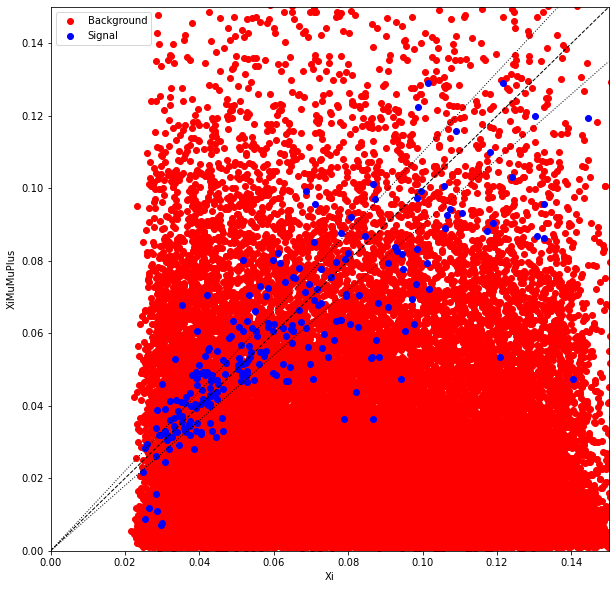

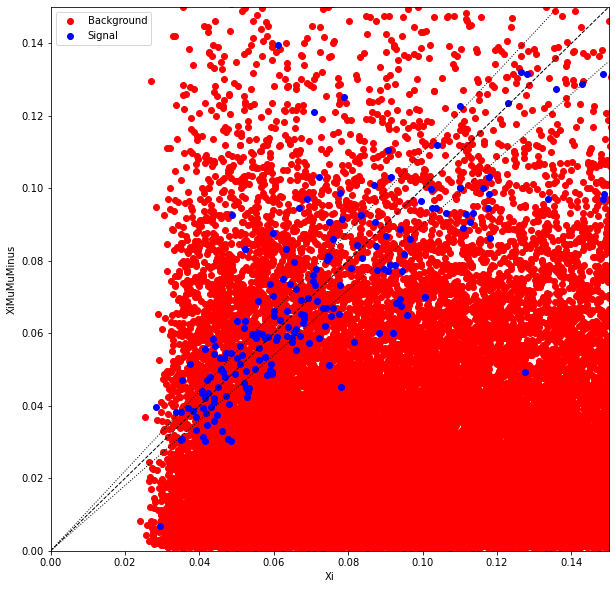

In [25]:
msk_bkg_1 = None
msk_bkg_2 = None
msk_sig_1 = None
msk_sig_2 = None
if proton_selection == "SingleRP":
    msk_bkg_1 = ( df_data_prep[ "RPId1" ] == 23 ) & ( df_data_prep['clf_category'] == 0 )
    msk_bkg_2 = ( df_data_prep[ "RPId1" ] == 123 ) & ( df_data_prep['clf_category'] == 0 )
    msk_sig_1 = ( df_data_prep[ "RPId1" ] == 23 ) & ( df_data_prep['clf_category'] == 1 )
    msk_sig_2 = ( df_data_prep[ "RPId1" ] == 123 ) & ( df_data_prep['clf_category'] == 1 )
elif proton_selection == "MultiRP":
    msk_bkg_1 = ( df_data_prep[ "Arm" ] == 0 ) & ( df_data_prep['clf_category'] == 0 )
    msk_bkg_2 = ( df_data_prep[ "Arm" ] == 1 ) & ( df_data_prep['clf_category'] == 0 )
    msk_sig_1 = ( df_data_prep[ "Arm" ] == 0 ) & ( df_data_prep['clf_category'] == 1 )
    msk_sig_2 = ( df_data_prep[ "Arm" ] == 1 ) & ( df_data_prep['clf_category'] == 1 )

Plot2D('Xi','XiMuMuPlus', df_data_prep,df_data_prep,msk_sig_1,msk_bkg_1)
Plot2D('Xi','XiMuMuMinus',df_data_prep,df_data_prep,msk_sig_2,msk_bkg_2)

Let's use the catgorization to plot the distributions of the variables for events which are classified as signal or as background.
Maybe these distributions can give some insight into the characteristics of the events which are falling under the signal category.

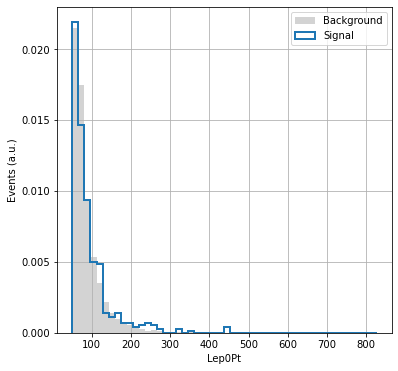

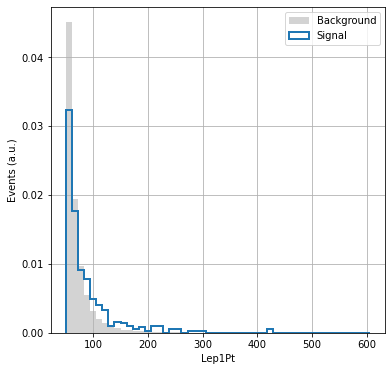

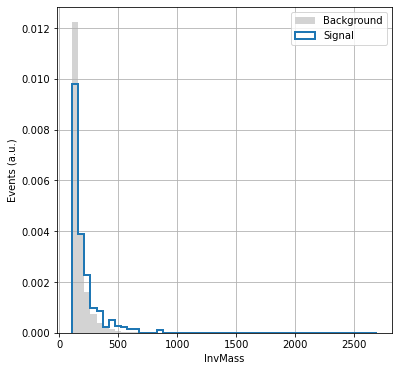

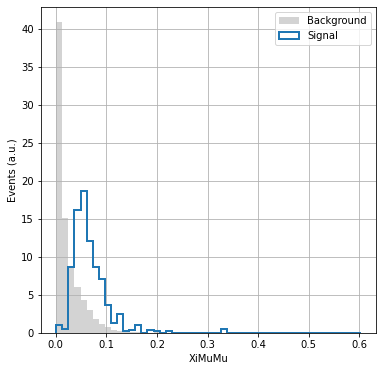

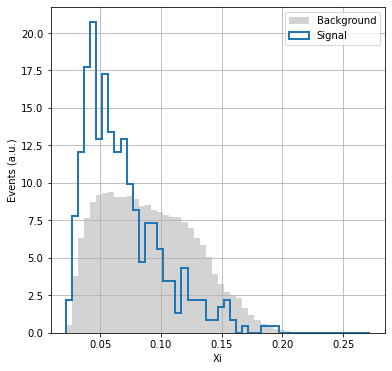

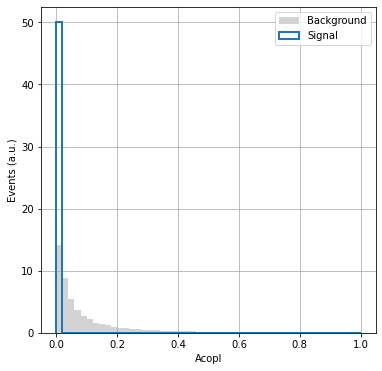

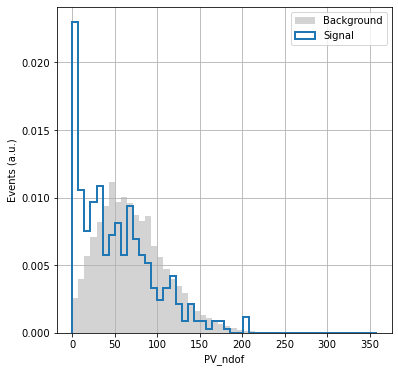

In [26]:
for x in train_vars:
    showDist(x,df_data_prep,(df_data_prep['clf_category']==1),(df_data_prep['clf_category']==0),50)

Finally, let's plot the events which have been classified as a signal against a background prediction,
based on the event-mixed data which has been used for the training of the MVA.

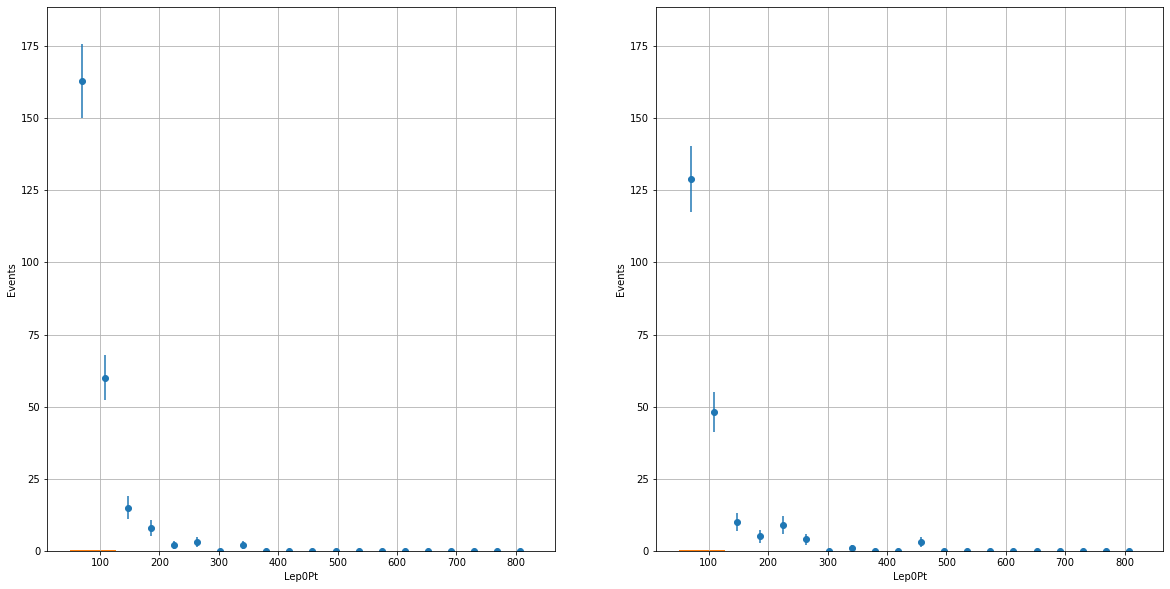

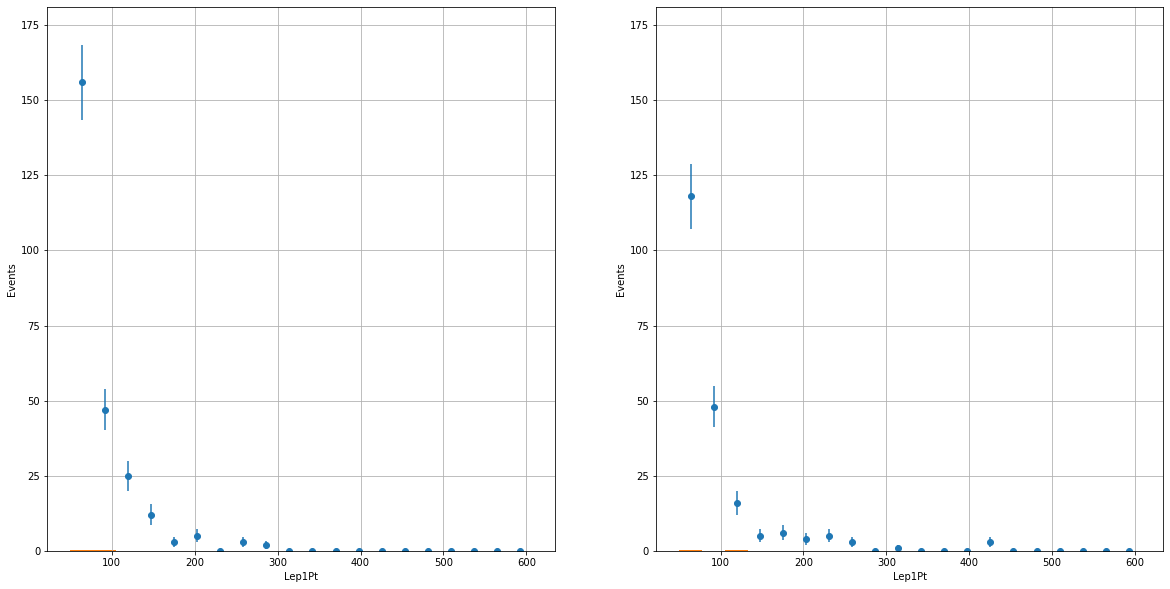

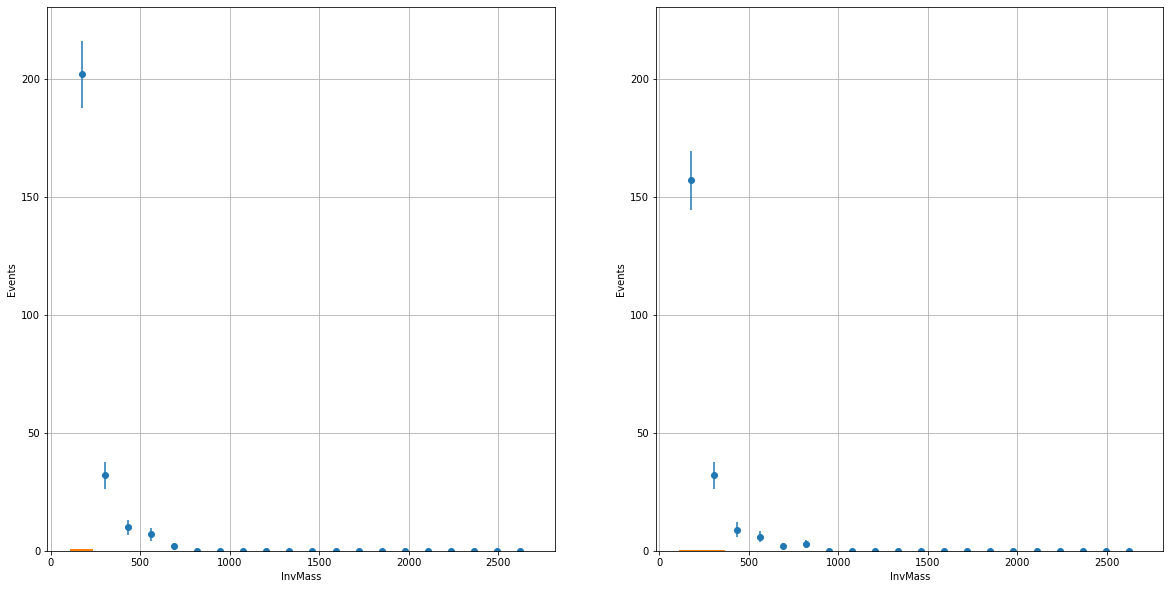

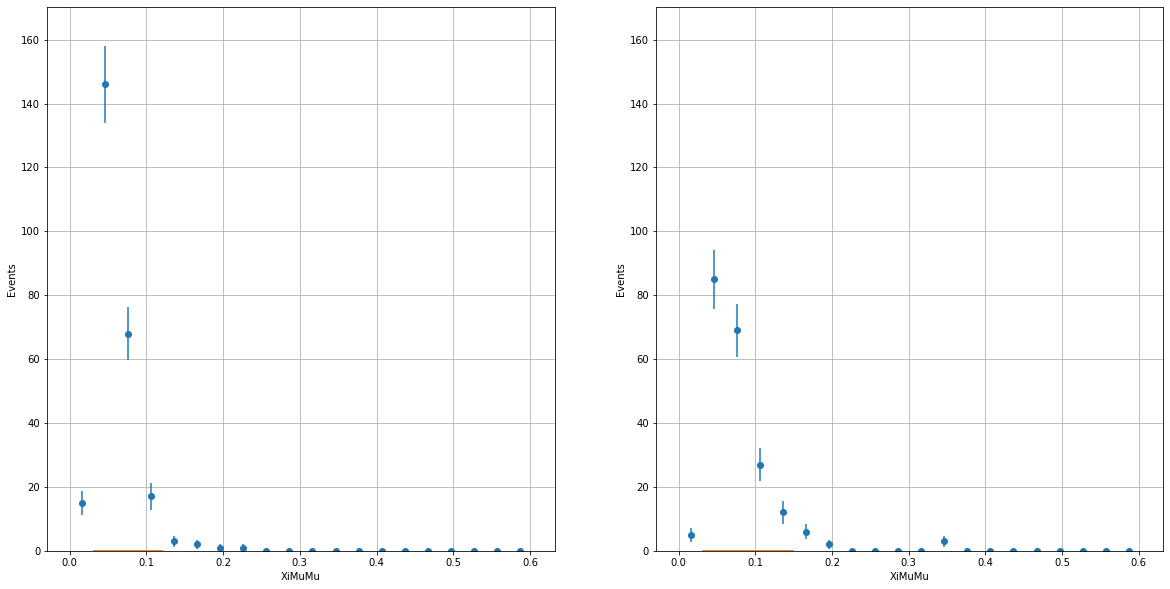

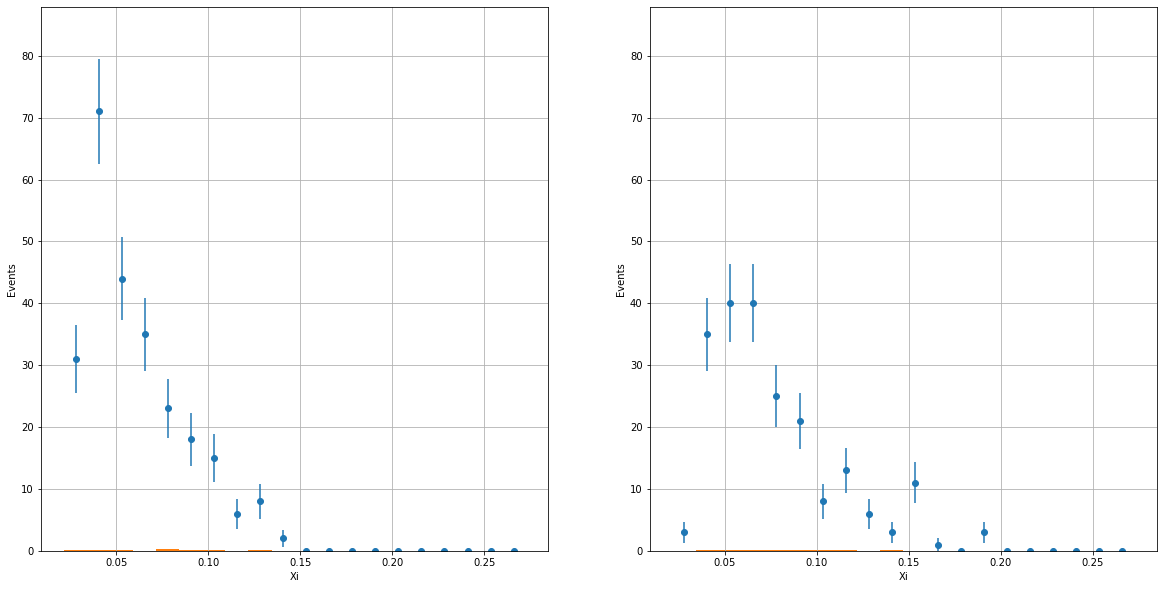

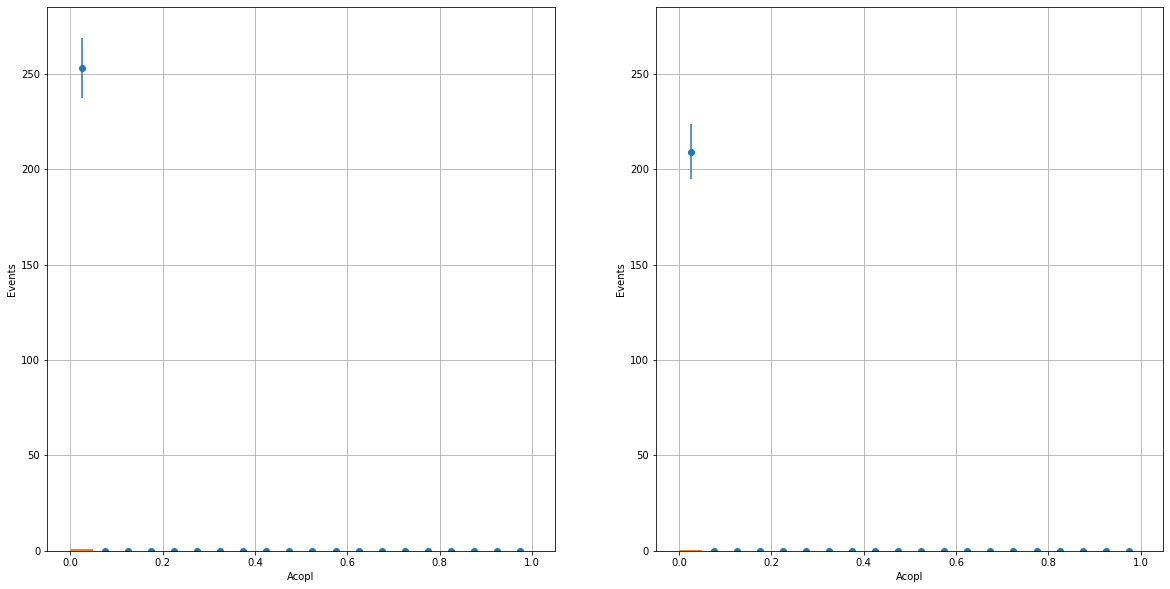

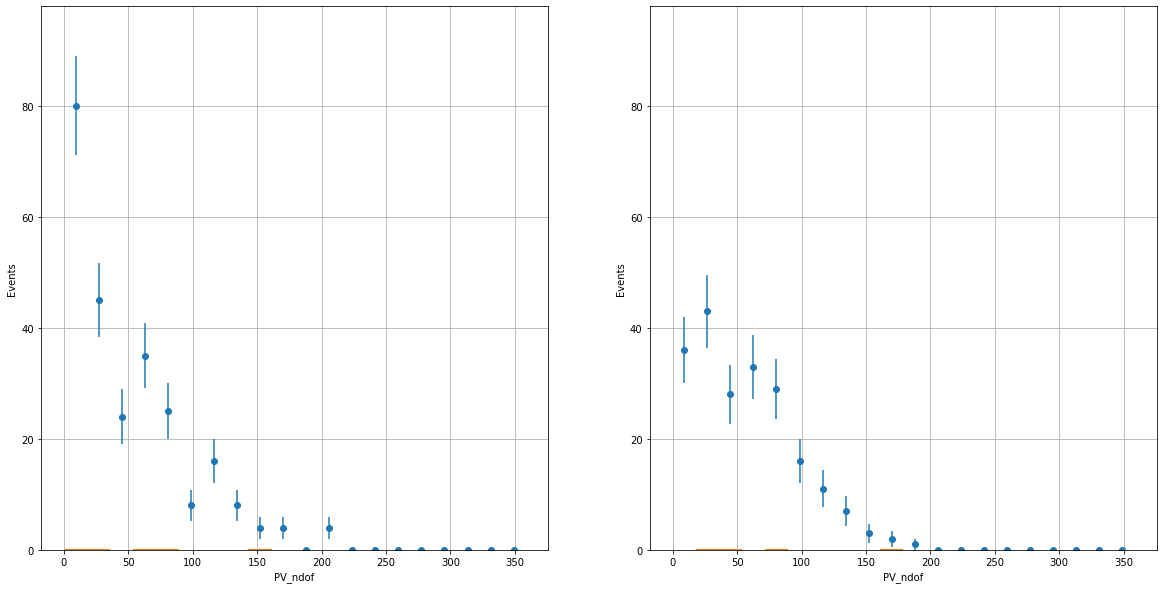

In [27]:
def compareToBackgroundPrediction(var,data,msk_data,bkg,msk_bkg,bins=20,resample_factor=20):

    fig, axes = plt.subplots( 1, 2, figsize=(20,10) )

    #define the binning if only nbins were given
    if isinstance(bins,int):
        _,bins=np.histogram(df_data_prep[var],bins=bins)

    counts={}
    errors={}
    for arm in [0,1]:
      
        counts[arm], bin_edges = np.histogram( data[var][msk_data[arm]], bins=bins )
        errors[arm] = np.sqrt( counts[arm] )
        bin_centres = ( bin_edges[:-1] + bin_edges[1:] ) / 2.
        axes[arm].errorbar(bin_centres, counts[arm], yerr=errors[arm], fmt='o', label='Data')

        weights = None
        if resample_factor > 1:
            weights = np.full_like( bkg[ "Xi" ][ msk_bkg[arm] ], ( 1./resample_factor ) )
    
        axes[arm].hist( bkg[ var ][ msk_bkg[arm] ], bins=bins, weights=weights, label='background' )
        
    #final tweak to display both y-axis with the same range
    idx_ymax = np.argmax( np.concatenate( [counts[0], counts[1]] ) )
    y_max = np.concatenate( [counts[0], counts[1]] )[idx_ymax] + 2*np.concatenate( [errors[0], errors[1]] )[idx_ymax]

    for arm in [0,1]:    
        axes[arm].set_ylim( top=y_max )
        axes[arm].set_ylabel('Events')
        axes[arm].set_xlabel(var)
        axes[arm].grid()

    plt.show()
        
msk_bkg_pred_1 = None
msk_bkg_pred_2 = None
if proton_selection == "SingleRP":
    msk_bkg_pred_1 = ( df_bkg_prep[ "RPId1" ] == 23 ) & ( y_bkg_pred == 1 )
    msk_bkg_pred_2 = ( df_bkg_prep[ "RPId1" ] == 123 ) & ( y_bkg_pred == 1 )
elif proton_selection == "MultiRP":
    msk_bkg_pred_1 = ( df_bkg_prep[ "Arm" ] == 0 ) & ( y_bkg_pred == 1 )
    msk_bkg_pred_2 = ( df_bkg_prep[ "Arm" ] == 1 ) & ( y_bkg_pred == 1 )

msk_data=[msk_sig_1,msk_sig_2]
msk_bkg=[msk_bkg_pred_1,msk_bkg_pred_2]
for var in train_vars:
    compareToBackgroundPrediction(var,df_data_prep,msk_data,df_bkg_prep,msk_bkg)

**TASK D**

Add the DeltaXi variable to the data and background data frames and plot it in the same style as before. 
What are your conclusions?

In [ ]:
#write your piece of code here

#stuck? uncomment the following piece of code and run to see the solution
#%load snippets/ClassificationTask3.py

**TASK E**

Once you are happy with the features, model and training, save your model so that it can be used for the statistical analysis.